## Imports

In [77]:
import numpy as np
import sympy as sp
import math as m
from sympy.utilities.lambdify import lambdify

from sympy import init_printing
init_printing(use_latex=True)
import matplotlib.pyplot as plt

from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

#fill the libraries import
#...

## Pure python function

In [78]:
def solve_1d_burger_pure(u, nt, nx, dt, dx, nu):
    
    #fill the update of u
    
    for n in range(nt):
        for i in range(1,nx-1):
            u[i]=u[i]-dt/dx*u[i]*(u[i]-u[i-1])+nu*dt/dx**2*(u[i+1]-2*u[i]+u[i-1])
        u[0]=u[0]-dt/dx*u[0]*(u[0]-u[-1])+nu*dt/dx**2*(u[1]-2*u[0]+u[-1])
        u[-1]=u[0]
            
    return 0

## Numba accelerator

In [79]:
@njit(fastmath=True)
def solve_1d_burger_numba(u, nt, nx, dt, dx, nu):
    
    #fill the update of u
    
    for n in range(nt):
        for i in range(1,nx-1):
            u[i]=u[i]-dt/dx*u[i]*(u[i]-u[i-1])+nu*dt/dx**2*(u[i+1]-2*u[i]+u[i-1])  
            
    u[0]=u[0]-dt/dx*u[0]*(u[0]-u[-1])+nu*dt/dx**2*(u[1]-2*u[0]+u[-1])
    
    u[-1]=u[0]
            
            
        
        
    return 0

## Pyccel accelerator

In [80]:
@types('float[:]', 'int', 'int', 'float', 'float', 'float')
def solve_1d_burger_pyccel(u, nt, nx, dt, dx, nu):
    
    #fill the update of u
    
    for n in range(nt):
        for i in range(1,nx-1):
            
            u[i]=u[i]-dt/dx*u[i]*(u[i]-u[i-1])+nu*dt/dx**2*(u[i+1]-2*u[i]+u[i-1])
            
        u[0]=u[0]-dt/dx*u[0]*(u[0]-u[-2])+nu*dt/dx**2*(u[1]-2*u[0]+u[-2])
        
        u[-1]=u[0]
       
    return 0

## Inputs

In [81]:
#sympy computation
x, nu, t = sp.symbols('x nu t')
phi = (sp.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
       sp.exp(-(x - 4 * t - 2 * sp.pi)**2 / (4 * nu * (t + 1))))

phiprime = phi.diff(x)
u = -2 * nu * (phiprime / phi) + 4
ufunc = lambdify((t, x, nu), u)

In [82]:
###variable declarations
nx = 201
nt = 100
dx = 2 * np.pi / (nx - 1)
nu = .07
dt = dx * nu

x = np.linspace(0, 2 * np.pi, nx)
t = 0

## Plot initial condition

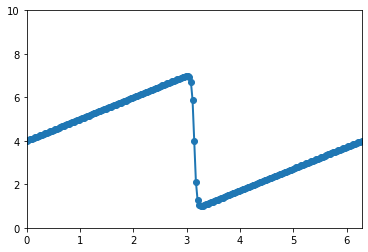

In [83]:
u = np.asarray([ufunc(t, x0, nu) for x0 in x])
plt.figure()
plt.plot(x, u, marker='o', lw=2)
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10]);

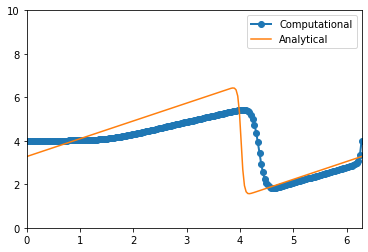

In [84]:
solve_1d_burger_pure(u, nt, nx, dt, dx, nu)

# Analytical solution
u_analytical = np.asarray([ufunc(nt * dt, xi, nu) for xi in x])


#Plotting data
plt.figure()
plt.plot(x,u, marker='o', lw=2, label='Computational')
plt.plot(x, u_analytical, label='Analytical')
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10])
plt.legend()

## Call Funtions

### Pure function

In [76]:
%timeit solve_1d_burger_pure(u, nt, nx, dt, dx, nu)

44.2 ms ± 4.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Function with numba accelerator

In [75]:
%timeit solve_1d_burger_numba(u, nt, nx, dt, dx, nu)

96.7 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Function with pyccel accelerator

In [74]:
solve_1d_burger_f90 = epyccel(solve_1d_burger_pyccel)


In [73]:
%timeit solve_1d_burger_f90(u, nt, nx, dt, dx, nu)

93.5 µs ± 287 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
